## Assignment-20: Quora question pair similarity

<h1> 1. Business Problem </h1>

<h2> 1.1 Description </h2>

<p>Quora is a place to gain and share knowledge—about anything. It’s a platform to ask questions and connect with people who contribute unique insights and quality answers. This empowers people to learn from each other and to better understand the world.</p>
<p>
Over 100 million people visit Quora every month, so it's no surprise that many people ask similarly worded questions. Multiple questions with the same intent can cause seekers to spend more time finding the best answer to their question, and make writers feel they need to answer multiple versions of the same question. Quora values canonical questions because they provide a better experience to active seekers and writers, and offer more value to both of these groups in the long term.
</p>
<br>
> Credits: Kaggle 


In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import re
import time
import warnings
import sqlite3
from sqlalchemy import create_engine # database connection
import csv
import os
warnings.filterwarnings("ignore")
warnings.simplefilter(action='ignore',category=FutureWarning)
import datetime as dt
import numpy as np
from nltk.corpus import stopwords
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import normalize
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.manifold import TSNE
import seaborn as sns
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics.classification import accuracy_score, log_loss
from sklearn.feature_extraction.text import TfidfVectorizer
from collections import Counter
from scipy.sparse import hstack
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC
from sklearn.cross_validation import StratifiedKFold 
from collections import Counter, defaultdict
from sklearn.calibration import CalibratedClassifierCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
import math
from sklearn.metrics import normalized_mutual_info_score
from sklearn.ensemble import RandomForestClassifier


__ Problem Statement __
- Identify which questions asked on Quora are duplicates of questions that have already been asked. 
- This could be useful to instantly provide answers to questions that have already been answered. 
- We are tasked with predicting whether a pair of questions are duplicates or not. 

<h2> 1.2 Sources/Useful Links</h2>

- Source : https://www.kaggle.com/c/quora-question-pairs
<br><br>____ Useful Links ____
- Discussions : https://www.kaggle.com/anokas/data-analysis-xgboost-starter-0-35460-lb/comments
- Kaggle Winning Solution and other approaches: https://www.dropbox.com/sh/93968nfnrzh8bp5/AACZdtsApc1QSTQc7X0H3QZ5a?dl=0
- Blog 1 : https://engineering.quora.com/Semantic-Question-Matching-with-Deep-Learning
- Blog 2 : https://towardsdatascience.com/identifying-duplicate-questions-on-quora-top-12-on-kaggle-4c1cf93f1c30

<h2>1.3 Real world/Business Objectives and Constraints </h2>

1. The cost of a mis-classification can be very high.
2. You would want a probability of a pair of questions to be duplicates so that you can choose any threshold of choice.
3. No strict latency concerns.
4. Interpretability is partially important.

<h1>2. Machine Learning Probelm </h1>

<h2> 2.1 Data </h2>

<h3> 2.1.1 Data Overview </h3>

<p> 
- Data will be in a file Train.csv <br>
- Train.csv contains 5 columns : qid1, qid2, question1, question2, is_duplicate <br>
- Size of Train.csv - 60MB <br>
- Number of rows in Train.csv = 404,290
</p>

<h3> 2.1.2 Example Data point </h3>

<pre>
"id","qid1","qid2","question1","question2","is_duplicate"
"0","1","2","What is the step by step guide to invest in share market in india?","What is the step by step guide to invest in share market?","0"
"1","3","4","What is the story of Kohinoor (Koh-i-Noor) Diamond?","What would happen if the Indian government stole the Kohinoor (Koh-i-Noor) diamond back?","0"
"7","15","16","How can I be a good geologist?","What should I do to be a great geologist?","1"
"11","23","24","How do I read and find my YouTube comments?","How can I see all my Youtube comments?","1"
</pre>

<h2> 2.2 Mapping the real world problem to an ML problem </h2>

<h3> 2.2.1 Type of Machine Leaning Problem </h3>

<p> It is a binary classification problem, for a given pair of questions we need to predict if they are duplicate or not. </p>

<h3> 2.2.2 Performance Metric </h3>

Source: https://www.kaggle.com/c/quora-question-pairs#evaluation

Metric(s): 
* log-loss : https://www.kaggle.com/wiki/LogarithmicLoss
* Binary Confusion Matrix

<h2> 2.3 Train and Test Construction </h2>

<p>  </p>
<p> We build train and test by randomly splitting in the ratio of 70:30 or 80:20 whatever we choose as we have sufficient points to work with. </p>

<h1>3. Exploratory Data Analysis </h1>

In [4]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from subprocess import check_output
%matplotlib inline
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls
import os
import gc

import re
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
import distance # customized library
from wordcloud import WordCloud, STOPWORDS
from os import path
from PIL import Image
from fuzzywuzzy import fuzz
from sklearn.manifold import TSNE

from sklearn.preprocessing import normalize
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from tqdm import tqdm
import spacy
from bs4 import BeautifulSoup

import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter(action='ignore',category=FutureWarning)

/anaconda3/lib/python3.6/site-packages/fuzzywuzzy/fuzz.py:11: UserWarning:

Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning



<h2> 3.1 Reading data and basic stats </h2>

In [5]:
df = pd.read_csv("/Users/mohdsaquib/Downloads/train.csv")

print("Number of data points:",df.shape[0])

Number of data points: 404290


In [6]:
df.head()

id  qid1  qid2                                          question1  \
0   0     1     2  What is the step by step guide to invest in sh...   
1   1     3     4  What is the story of Kohinoor (Koh-i-Noor) Dia...   
2   2     5     6  How can I increase the speed of my internet co...   
3   3     7     8  Why am I mentally very lonely? How can I solve...   
4   4     9    10  Which one dissolve in water quikly sugar, salt...   

                                           question2  is_duplicate  
0  What is the step by step guide to invest in sh...             0  
1  What would happen if the Indian government sto...             0  
2  How can Internet speed be increased by hacking...             0  
3  Find the remainder when [math]23^{24}[/math] i...             0  
4            Which fish would survive in salt water?             0

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 404290 entries, 0 to 404289
Data columns (total 6 columns):
id              404290 non-null int64
qid1            404290 non-null int64
qid2            404290 non-null int64
question1       404289 non-null object
question2       404288 non-null object
is_duplicate    404290 non-null int64
dtypes: int64(4), object(2)
memory usage: 18.5+ MB


We are given a minimal number of data fields here, consisting of:

- id:  Looks like a simple rowID
- qid{1, 2}:  The unique ID of each question in the pair
- question{1, 2}:  The actual textual contents of the questions.
- is_duplicate:  The label that we are trying to predict - whether the two questions are duplicates of each other.

<h3> 3.2.1 Distribution of data points among output classes</h3>
- Number of duplicate(smilar) and non-duplicate(non similar) questions

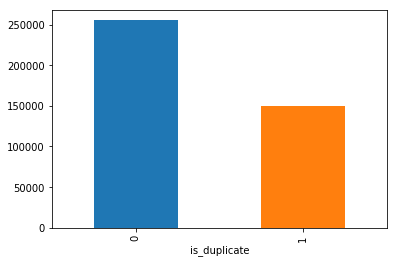

In [8]:
df.groupby("is_duplicate")['id'].count().plot.bar()

In [9]:
print('~> Total number of question pairs for training:\n   {}'.format(len(df)))

~> Total number of question pairs for training:
   404290


In [10]:
print('~> Question pairs are not Similar (is_duplicate = 0):\n   {}%'.format(100 - round(df['is_duplicate'].mean()*100, 2)))
print('\n~> Question pairs are Similar (is_duplicate = 1):\n   {}%'.format(round(df['is_duplicate'].mean()*100, 2)))

~> Question pairs are not Similar (is_duplicate = 0):
   63.08%

~> Question pairs are Similar (is_duplicate = 1):
   36.92%


<h3> 3.2.2 Number of unique questions </h3>

In [11]:
qids = pd.Series(df['qid1'].tolist() + df['qid2'].tolist())
unique_qs = len(np.unique(qids))
qs_morethan_onetime = np.sum(qids.value_counts() > 1)
print ('Total number of  Unique Questions are: {}\n'.format(unique_qs))
#print len(np.unique(qids))

print ('Number of unique questions that appear more than one time: {} ({}%)\n'.format(qs_morethan_onetime,qs_morethan_onetime/unique_qs*100))

print ('Max number of times a single question is repeated: {}\n'.format(max(qids.value_counts()))) 

q_vals=qids.value_counts()

q_vals=q_vals.values

Total number of  Unique Questions are: 537933

Number of unique questions that appear more than one time: 111780 (20.77953945937505%)

Max number of times a single question is repeated: 157



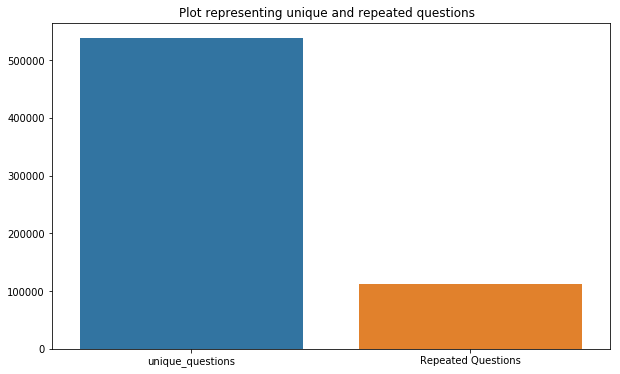

In [12]:

x = ["unique_questions" , "Repeated Questions"]
y =  [unique_qs , qs_morethan_onetime]

plt.figure(figsize=(10, 6))
plt.title ("Plot representing unique and repeated questions  ")
sns.barplot(x,y)
plt.show()

<h3>3.2.3 Checking for Duplicates </h3>

In [13]:
#checking whether there are any repeated pair of questions

pair_duplicates = df[['qid1','qid2','is_duplicate']].groupby(['qid1','qid2']).count().reset_index()

print ("Number of duplicate questions",(pair_duplicates).shape[0] - df.shape[0])

Number of duplicate questions 0


<h3> 3.2.4 Number of occurrences of each question </h3>

Maximum number of times a single question is repeated: 157



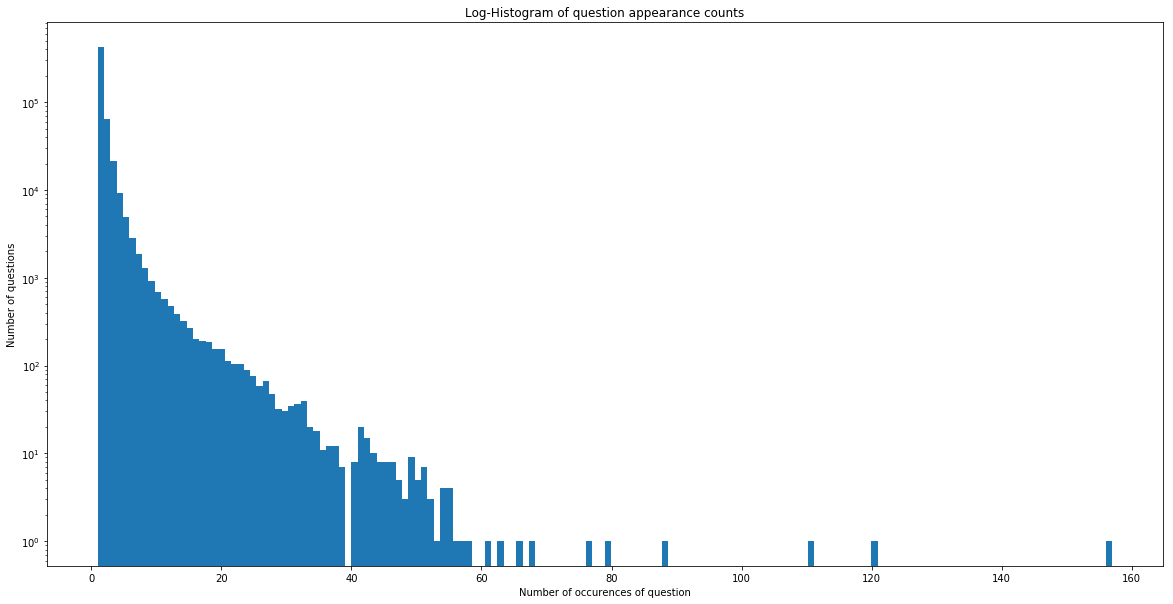

In [14]:
plt.figure(figsize=(20, 10))

plt.hist(qids.value_counts(), bins=160)

plt.yscale('log', nonposy='clip')

plt.title('Log-Histogram of question appearance counts')

plt.xlabel('Number of occurences of question')

plt.ylabel('Number of questions')

print ('Maximum number of times a single question is repeated: {}\n'.format(max(qids.value_counts()))) 

<h3> 3.2.5 Checking for NULL values </h3>

In [15]:
#Checking whether there are any rows with null values
nan_rows = df[df.isnull().any(1)]
print (nan_rows)

            id    qid1    qid2                         question1  \
105780  105780  174363  174364    How can I develop android app?   
201841  201841  303951  174364  How can I create an Android app?   
363362  363362  493340  493341                               NaN   

                                                question2  is_duplicate  
105780                                                NaN             0  
201841                                                NaN             0  
363362  My Chinese name is Haichao Yu. What English na...             0  


- There are two rows with null values in question2 

In [16]:
# Filling the null values with ' '
df = df.fillna('')
nan_rows = df[df.isnull().any(1)]
print (nan_rows)

Empty DataFrame
Columns: [id, qid1, qid2, question1, question2, is_duplicate]
Index: []


<h2>3.3 Basic Feature Extraction (before cleaning) </h2>

Let us now construct a few features like:
 - ____freq_qid1____ = Frequency of qid1's
 - ____freq_qid2____ = Frequency of qid2's 
 - ____q1len____ = Length of q1
 - ____q2len____ = Length of q2
 - ____q1_n_words____ = Number of words in Question 1
 - ____q2_n_words____ = Number of words in Question 2
 - ____word_Common____ = (Number of common unique words in Question 1 and Question 2)
 - ____word_Total____ =(Total num of words in Question 1 + Total num of words in Question 2)
 - ____word_share____ = (word_common)/(word_Total)
 - ____freq_q1+freq_q2____ = sum total of frequency of qid1 and qid2 
 - ____freq_q1-freq_q2____ = absolute difference of frequency of qid1 and qid2 

In [17]:
if os.path.isfile('df_fe_without_preprocessing_train.csv'):
    df = pd.read_csv("df_fe_without_preprocessing_train.csv",encoding='latin-1')
else:
    df['freq_qid1'] = df.groupby('qid1')['qid1'].transform('count') 
    df['freq_qid2'] = df.groupby('qid2')['qid2'].transform('count')
    df['q1len'] = df['question1'].str.len() 
    df['q2len'] = df['question2'].str.len()
    df['q1_n_words'] = df['question1'].apply(lambda row: len(row.split(" ")))
    df['q2_n_words'] = df['question2'].apply(lambda row: len(row.split(" ")))

    def normalized_word_Common(row):
        w1 = set(map(lambda word: word.lower().strip(), row['question1'].split(" ")))
        w2 = set(map(lambda word: word.lower().strip(), row['question2'].split(" ")))    
        return 1.0 * len(w1 & w2)
    df['word_Common'] = df.apply(normalized_word_Common, axis=1)

    def normalized_word_Total(row):
        w1 = set(map(lambda word: word.lower().strip(), row['question1'].split(" ")))
        w2 = set(map(lambda word: word.lower().strip(), row['question2'].split(" ")))    
        return 1.0 * (len(w1) + len(w2))
    df['word_Total'] = df.apply(normalized_word_Total, axis=1)

    def normalized_word_share(row):
        w1 = set(map(lambda word: word.lower().strip(), row['question1'].split(" ")))
        w2 = set(map(lambda word: word.lower().strip(), row['question2'].split(" ")))    
        return 1.0 * len(w1 & w2)/(len(w1) + len(w2))
    df['word_share'] = df.apply(normalized_word_share, axis=1)

    df['freq_q1+q2'] = df['freq_qid1']+df['freq_qid2']
    df['freq_q1-q2'] = abs(df['freq_qid1']-df['freq_qid2'])

    df.to_csv("df_fe_without_preprocessing_train.csv", index=False)

df.head()

id  qid1  qid2                                          question1  \
0   0     1     2  What is the step by step guide to invest in sh...   
1   1     3     4  What is the story of Kohinoor (Koh-i-Noor) Dia...   
2   2     5     6  How can I increase the speed of my internet co...   
3   3     7     8  Why am I mentally very lonely? How can I solve...   
4   4     9    10  Which one dissolve in water quikly sugar, salt...   

                                           question2  is_duplicate  freq_qid1  \
0  What is the step by step guide to invest in sh...             0          1   
1  What would happen if the Indian government sto...             0          4   
2  How can Internet speed be increased by hacking...             0          1   
3  Find the remainder when [math]23^{24}[/math] i...             0          1   
4            Which fish would survive in salt water?             0          3   

   freq_qid2  q1len  q2len  q1_n_words  q2_n_words  word_Common  word_Total  \
0          1     66     57          14          12         10.0        23.0   
1          1     51     88           8          13          4.0        20.0   
2          1     73     59          14          10          4.0        24.0   
3          1     50     65          11           9          0.0        19.0   
4          1     76     39          13           7          2.0        20.0   

   word_share  freq_q1+q2  freq_q1-q2  
0    0.434783           2           0  
1    0.200000           5           3  
2    0.166667           2           0  
3    0.000000           2           0  
4    0.100000           4           2

<h3> 3.3.1 Analysis of some of the extracted features </h3>

- Here are some questions have only one single words.

In [18]:
print ("Minimum length of the questions in question1 : " , min(df['q1_n_words']))

print ("Minimum length of the questions in question2 : " , min(df['q2_n_words']))

print ("Number of Questions with minimum length [question1] :", df[df['q1_n_words']== 1].shape[0])
print ("Number of Questions with minimum length [question2] :", df[df['q2_n_words']== 1].shape[0])

Minimum length of the questions in question1 :  1
Minimum length of the questions in question2 :  1
Number of Questions with minimum length [question1] : 67
Number of Questions with minimum length [question2] : 24


<h4> 3.3.1.1 Feature: word_share </h4>

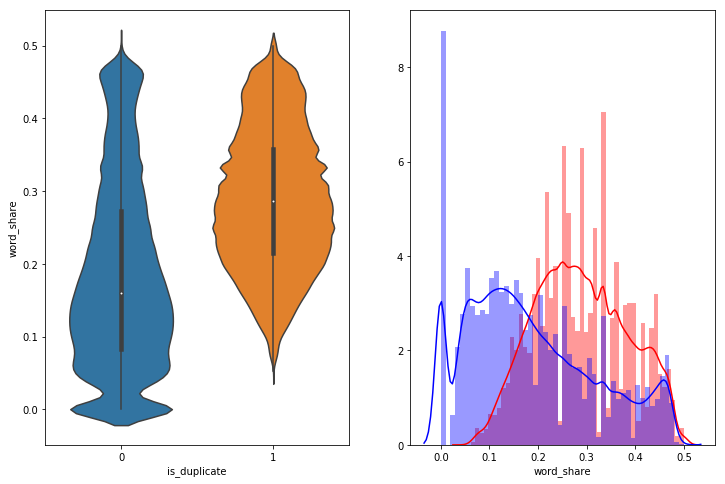

In [19]:
plt.figure(figsize=(12, 8))

plt.subplot(1,2,1)
sns.violinplot(x = 'is_duplicate', y = 'word_share', data = df[0:])

plt.subplot(1,2,2)
sns.distplot(df[df['is_duplicate'] == 1.0]['word_share'][0:] , label = "1", color = 'red')
sns.distplot(df[df['is_duplicate'] == 0.0]['word_share'][0:] , label = "0" , color = 'blue' )
plt.show()

- The distributions for normalized word_share have some overlap on the far right-hand side, i.e., there are quite a lot of questions with high word similarity
- The average word share and Common no. of words of qid1 and qid2 is more when they are duplicate(Similar)

<h4> 3.3.1.2 Feature: word_Common </h4>

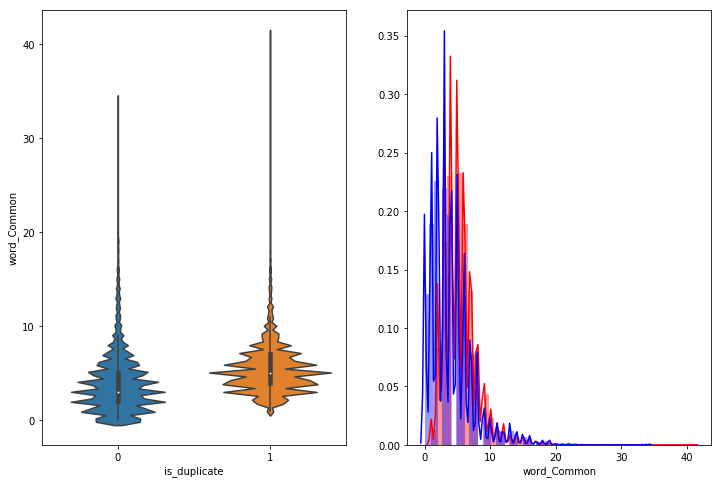

In [20]:
plt.figure(figsize=(12, 8))

plt.subplot(1,2,1)
sns.violinplot(x = 'is_duplicate', y = 'word_Common', data = df[0:])

plt.subplot(1,2,2)
sns.distplot(df[df['is_duplicate'] == 1.0]['word_Common'][0:] , label = "1", color = 'red')
sns.distplot(df[df['is_duplicate'] == 0.0]['word_Common'][0:] , label = "0" , color = 'blue' )
plt.show()

<p> The distributions of the word_Common feature in similar and non-similar questions are highly overlapping </p>

## EDA- Advanced Feature Extraction

In [21]:
import warnings
warnings.filterwarnings("ignore")
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from subprocess import check_output
%matplotlib inline
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls
import os
import gc

import re
from nltk.corpus import stopwords
import distance
from nltk.stem import PorterStemmer
from bs4 import BeautifulSoup
import re
from nltk.corpus import stopwords
# This package is used for finding longest common subsequence between two strings
# you can write your own dp code for this
import distance
from nltk.stem import PorterStemmer
from bs4 import BeautifulSoup
from fuzzywuzzy import fuzz
from sklearn.manifold import TSNE
# Import the Required lib packages for WORD-Cloud generation
# https://stackoverflow.com/questions/45625434/how-to-install-wordcloud-in-python3-6
from wordcloud import WordCloud, STOPWORDS
from os import path
from PIL import Image


In [22]:
#https://stackoverflow.com/questions/12468179/unicodedecodeerror-utf8-codec-cant-decode-byte-0x9c
if os.path.isfile('df_fe_without_preprocessing_train.csv'):
    df = pd.read_csv("df_fe_without_preprocessing_train.csv",encoding='latin-1')
    df = df.fillna('')
    df.head()
else:
    print("get df_fe_without_preprocessing_train.csv from drive or run the previous notebook")


In [23]:
df.head(2)

id  qid1  qid2                                          question1  \
0   0     1     2  What is the step by step guide to invest in sh...   
1   1     3     4  What is the story of Kohinoor (Koh-i-Noor) Dia...   

                                           question2  is_duplicate  freq_qid1  \
0  What is the step by step guide to invest in sh...             0          1   
1  What would happen if the Indian government sto...             0          4   

   freq_qid2  q1len  q2len  q1_n_words  q2_n_words  word_Common  word_Total  \
0          1     66     57          14          12         10.0        23.0   
1          1     51     88           8          13          4.0        20.0   

   word_share  freq_q1+q2  freq_q1-q2  
0    0.434783           2           0  
1    0.200000           5           3

## Preprocessing of Text
#### 1.Preprocessing:
#### 2.Removing html tags
#### 3.Removing Punctuations
#### 4.Performing stemming
#### 5.Removing Stopwords
#### 6.Expanding contractions etc.

In [24]:
# To get the results in 4 decemal points
SAFE_DIV = 0.0001 

STOP_WORDS = stopwords.words("english")


def preprocess(x):
    x = str(x).lower()
    x = x.replace(",000,000", "m").replace(",000", "k").replace("′", "'").replace("’", "'")\
                           .replace("won't", "will not").replace("cannot", "can not").replace("can't", "can not")\
                           .replace("n't", " not").replace("what's", "what is").replace("it's", "it is")\
                           .replace("'ve", " have").replace("i'm", "i am").replace("'re", " are")\
                           .replace("he's", "he is").replace("she's", "she is").replace("'s", " own")\
                           .replace("%", " percent ").replace("₹", " rupee ").replace("$", " dollar ")\
                           .replace("€", " euro ").replace("'ll", " will")
    x = re.sub(r"([0-9]+)000000", r"\1m", x)
    x = re.sub(r"([0-9]+)000", r"\1k", x)
    
    
    porter = PorterStemmer()
    pattern = re.compile('\W')
    
    if type(x) == type(''):
        x = re.sub(pattern, ' ', x)
    
    
    if type(x) == type(''):
        x = porter.stem(x)
        example1 = BeautifulSoup(x)
        x = example1.get_text()
               
    
    return x

#### Function to Compute and get the features : With 2 parameters of Question 1 and Question 2

## 3.5 Advanced Feature Extraction (NLP and Fuzzy Features)

#### Definition:

#### Token: You get a token by splitting sentence a space
#### Stop_Word : stop words as per NLTK.
#### Word : A token that is not a stop_word


#### Features:

#### cwc_min : Ratio of common_word_count to min lenghth of word count of Q1 and Q2 
#### cwc_min = common_word_count / (min(len(q1_words), len(q2_words)) 

#### cwc_max : Ratio of common_word_count to max lenghth of word count of Q1 and Q2 
#### cwc_max = common_word_count / (max(len(q1_words), len(q2_words)) 

#### csc_min : Ratio of common_stop_count to min lenghth of stop count of Q1 and Q2 
#### csc_min = common_stop_count / (min(len(q1_stops), len(q2_stops)) 

#### csc_max : Ratio of common_stop_count to max lenghth of stop count of Q1 and Q2
#### csc_max = common_stop_count / (max(len(q1_stops), len(q2_stops)) 

#### ctc_min : Ratio of common_token_count to min lenghth of token count of Q1 and Q2
#### ctc_min = common_token_count / (min(len(q1_tokens), len(q2_tokens)) 


#### ctc_max : Ratio of common_token_count to max lenghth of token count of Q1 and Q2
#### ctc_max = common_token_count / (max(len(q1_tokens), len(q2_tokens)) 


#### last_word_eq : Check if First word of both questions is equal or not
#### last_word_eq = int(q1_tokens[-1] == q2_tokens[-1]) 


#### first_word_eq : Check if First word of both questions is equal or not
#### first_word_eq = int(q1_tokens[0] == q2_tokens[0]) 


#### abs_len_diff : Abs. length difference
#### abs_len_diff = abs(len(q1_tokens) - len(q2_tokens)) 

#### mean_len : Average Token Length of both Questions
#### mean_len = (len(q1_tokens) + len(q2_tokens))/2 


#### fuzz_ratio : https://github.com/seatgeek/fuzzywuzzy#usage http://chairnerd.seatgeek.com/fuzzywuzzy-fuzzy-string-matching-in-python/ 


#### fuzz_partial_ratio : https://github.com/seatgeek/fuzzywuzzy#usage http://chairnerd.seatgeek.com/fuzzywuzzy-fuzzy-string-matching-in-python/ 


#### token_sort_ratio : https://github.com/seatgeek/fuzzywuzzy#usage http://chairnerd.seatgeek.com/fuzzywuzzy-fuzzy-string-matching-in-python/ 

#### token_set_ratio : https://github.com/seatgeek/fuzzywuzzy#usage http://chairnerd.seatgeek.com/fuzzywuzzy-fuzzy-string-matching-in-python/ 

#### longest_substr_ratio : Ratio of length longest common substring to min lenghth of token count of Q1 and Q2
#### longest_substr_ratio = len(longest common substring) / (min(len(q1_tokens), len(q2_tokens))

In [25]:
def get_token_features(q1, q2):
    token_features = [0.0]*10
    
    # Converting the Sentence into Tokens: 
    q1_tokens = q1.split()
    q2_tokens = q2.split()

    if len(q1_tokens) == 0 or len(q2_tokens) == 0:
        return token_features
    # Get the non-stopwords in Questions
    q1_words = set([word for word in q1_tokens if word not in STOP_WORDS])
    q2_words = set([word for word in q2_tokens if word not in STOP_WORDS])
    
    #Get the stopwords in Questions
    q1_stops = set([word for word in q1_tokens if word in STOP_WORDS])
    q2_stops = set([word for word in q2_tokens if word in STOP_WORDS])
    
    # Get the common non-stopwords from Question pair
    common_word_count = len(q1_words.intersection(q2_words))
    
    # Get the common stopwords from Question pair
    common_stop_count = len(q1_stops.intersection(q2_stops))
    
    # Get the common Tokens from Question pair
    common_token_count = len(set(q1_tokens).intersection(set(q2_tokens)))
    
    
    token_features[0] = common_word_count / (min(len(q1_words), len(q2_words)) + SAFE_DIV)
    token_features[1] = common_word_count / (max(len(q1_words), len(q2_words)) + SAFE_DIV)
    token_features[2] = common_stop_count / (min(len(q1_stops), len(q2_stops)) + SAFE_DIV)
    token_features[3] = common_stop_count / (max(len(q1_stops), len(q2_stops)) + SAFE_DIV)
    token_features[4] = common_token_count / (min(len(q1_tokens), len(q2_tokens)) + SAFE_DIV)
    token_features[5] = common_token_count / (max(len(q1_tokens), len(q2_tokens)) + SAFE_DIV)
    # Last word of both question is same or not
    token_features[6] = int(q1_tokens[-1] == q2_tokens[-1])
    
    # First word of both question is same or not
    token_features[7] = int(q1_tokens[0] == q2_tokens[0])
    
    token_features[8] = abs(len(q1_tokens) - len(q2_tokens))
    
    #Average Token Length of both Questions
    token_features[9] = (len(q1_tokens) + len(q2_tokens))/2
    return token_features

# get the Longest Common sub string

def get_longest_substr_ratio(a, b):
    strs = list(distance.lcsubstrings(a, b))
    if len(strs) == 0:
        return 0
    else:
        return len(strs[0]) / (min(len(a), len(b)) + 1)

def extract_features(df):
    # preprocessing each question
    df["question1"] = df["question1"].fillna("").apply(preprocess)
    df["question2"] = df["question2"].fillna("").apply(preprocess)

    print("token features...")
    
    # Merging Features with dataset
    
    token_features = df.apply(lambda x: get_token_features(x["question1"], x["question2"]), axis=1)
    
    df["cwc_min"]       = list(map(lambda x: x[0], token_features))
    df["cwc_max"]       = list(map(lambda x: x[1], token_features))
    df["csc_min"]       = list(map(lambda x: x[2], token_features))
    df["csc_max"]       = list(map(lambda x: x[3], token_features))
    df["ctc_min"]       = list(map(lambda x: x[4], token_features))
    df["ctc_max"]       = list(map(lambda x: x[5], token_features))
    df["last_word_eq"]  = list(map(lambda x: x[6], token_features))
    df["first_word_eq"] = list(map(lambda x: x[7], token_features))
    df["abs_len_diff"]  = list(map(lambda x: x[8], token_features))
    df["mean_len"]      = list(map(lambda x: x[9], token_features))
   
    #Computing Fuzzy Features and Merging with Dataset
    
    # do read this blog: http://chairnerd.seatgeek.com/fuzzywuzzy-fuzzy-string-matching-in-python/
    # https://stackoverflow.com/questions/31806695/when-to-use-which-fuzz-function-to-compare-2-strings
    # https://github.com/seatgeek/fuzzywuzzy
    print("fuzzy features..")

    df["token_set_ratio"]       = df.apply(lambda x: fuzz.token_set_ratio(x["question1"], x["question2"]), axis=1)
    # The token sort approach involves tokenizing the string in question, sorting the tokens alphabetically, and 
    # then joining them back into a string We then compare the transformed strings with a simple ratio().
    df["token_sort_ratio"]      = df.apply(lambda x: fuzz.token_sort_ratio(x["question1"], x["question2"]), axis=1)
    df["fuzz_ratio"]            = df.apply(lambda x: fuzz.QRatio(x["question1"], x["question2"]), axis=1)
    df["fuzz_partial_ratio"]    = df.apply(lambda x: fuzz.partial_ratio(x["question1"], x["question2"]), axis=1)
    df["longest_substr_ratio"]  = df.apply(lambda x: get_longest_substr_ratio(x["question1"], x["question2"]), axis=1)
    return df

In [26]:
if os.path.isfile('nlp_features_train.csv'):
    df = pd.read_csv("nlp_features_train.csv",encoding='latin-1')
    df.fillna('')
else:
    print("Extracting features for train:")
    df = pd.read_csv("/Users/mohdsaquib/downloads/train.csv")
    df = extract_features(df)
    df.to_csv("nlp_features_train.csv", index=False)
df.head(2)

id  qid1  qid2                                          question1  \
0   0     1     2  what is the step by step guide to invest in sh...   
1   1     3     4  what is the story of kohinoor  koh i noor  dia...   

                                           question2  is_duplicate   cwc_min  \
0  what is the step by step guide to invest in sh...             0  0.999980   
1  what would happen if the indian government sto...             0  0.799984   

    cwc_max   csc_min   csc_max          ...            ctc_max  last_word_eq  \
0  0.833319  0.999983  0.999983          ...           0.785709           0.0   
1  0.399996  0.749981  0.599988          ...           0.466664           0.0   

   first_word_eq  abs_len_diff  mean_len  token_set_ratio  token_sort_ratio  \
0            1.0           2.0      13.0              100                93   
1            1.0           5.0      12.5               86                63   

   fuzz_ratio  fuzz_partial_ratio  longest_substr_ratio  
0          93                 100              0.982759  
1          66                  75              0.596154  

[2 rows x 21 columns]

## Analysis of Extracted Feature

#### Plotting Word clouds
#### Creating Word Cloud of Duplicates and Non-Duplicates Question pairs
#### We can observe the most frequent occuring words

In [27]:
df_duplicate = df[df['is_duplicate']==1]
df_non_duplicate = df[df['is_duplicate']==0]

# Converting 2d array of q1 and q2 and flatten the array: like {{1,2},{3,4}} to {1,2,3,4}
p = np.dstack([df_duplicate['question1'],df_duplicate['question2']]).flatten()
n = np.dstack([df_non_duplicate['question1'],df_non_duplicate['question2']]).flatten()

print ("Number of data points in class 1 (duplicate pairs) :",len(p))
print ("Number of data points in class 0 (non duplicate pairs) :",len(n))

#Saving the np array into a text file
np.savetxt('train_p.txt', p, delimiter=' ', fmt='%s',encoding = 'utf-8')
np.savetxt('train_n.txt', n, delimiter=' ', fmt='%s',encoding = 'utf-8')

Number of data points in class 1 (duplicate pairs) : 298526
Number of data points in class 0 (non duplicate pairs) : 510054


In [28]:
# reading the text files and removing the Stop Words:
d = path.dirname('.')

textp_w = open(path.join(d, 'train_p.txt')).read()
textn_w = open(path.join(d, 'train_n.txt')).read()
stopwords = set(STOPWORDS)
stopwords.add("said")
stopwords.add("br")
stopwords.add(" ")
stopwords.remove("not")
stopwords.remove("like")
stopwords.remove("no")
print ("Total number of words in duplicate pair questions :",len(textp_w))
print ("Total number of words in non duplicate pair questions :",len(textn_w))

Total number of words in duplicate pair questions : 16110763
Total number of words in non duplicate pair questions : 33201102


### Word Clouds generated from duplicate pair question's text

In [29]:
plt.figure(figsize=(30,20))
wc = WordCloud(background_color='black',mode='RGB',max_font_size=100,max_words = len(textp_w),stopwords = stopwords,width=800, height=400)
wc.generate(textp_w)
print ("Word Cloud for Duplicate Question pairs")
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()

Word Cloud for Duplicate Question pairs



### Word Clouds generated from non duplicate pair question's text

In [30]:
plt.figure(figsize=(30,20))
wc = WordCloud(background_color='black',mode='RGB',max_font_size=100,max_words = len(textn_w),stopwords = stopwords,width=800, height=400)
wc.generate(textn_w)
print ("Word Cloud for Duplicate Question pairs")
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()

Word Cloud for Duplicate Question pairs


## 3.5.1.2 Pair plot of features ['ctc_min', 'cwc_min', 'csc_min', 'token_sort_ratio']

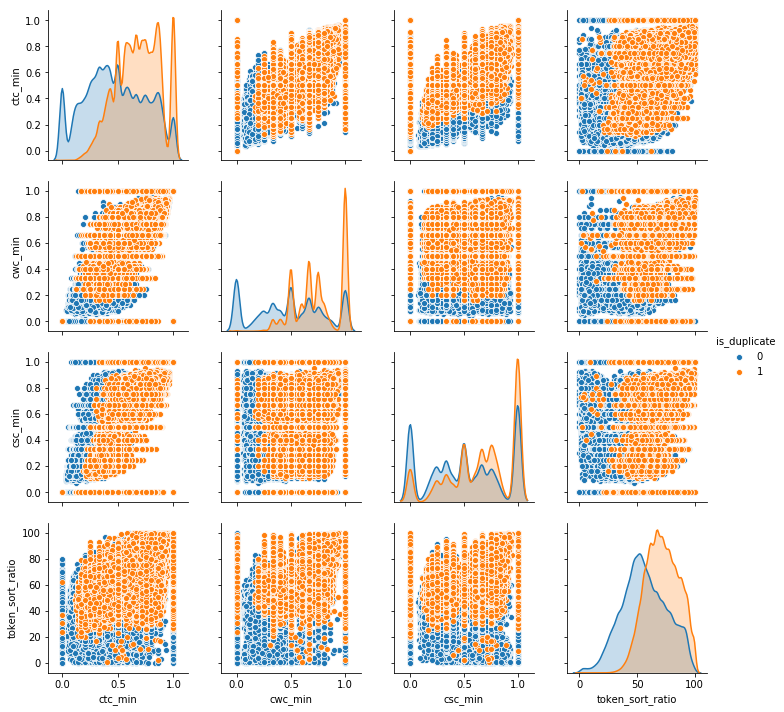

In [31]:
n = df.shape[0]
sns.pairplot(df[['ctc_min', 'cwc_min', 'csc_min', 'token_sort_ratio', 'is_duplicate']][0:n], hue='is_duplicate', vars=['ctc_min', 'cwc_min', 'csc_min', 'token_sort_ratio'])
plt.show()

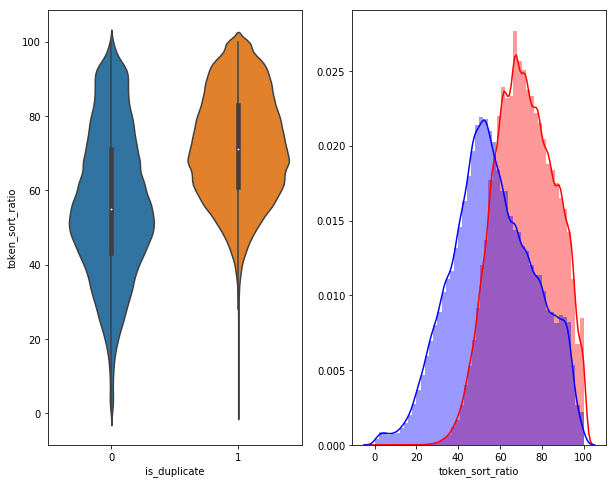

In [32]:
# Distribution of the token_sort_ratio
plt.figure(figsize=(10, 8))

plt.subplot(1,2,1)
sns.violinplot(x = 'is_duplicate', y = 'token_sort_ratio', data = df[0:] , )

plt.subplot(1,2,2)
sns.distplot(df[df['is_duplicate'] == 1.0]['token_sort_ratio'][0:] , label = "1", color = 'red')
sns.distplot(df[df['is_duplicate'] == 0.0]['token_sort_ratio'][0:] , label = "0" , color = 'blue' )
plt.show()

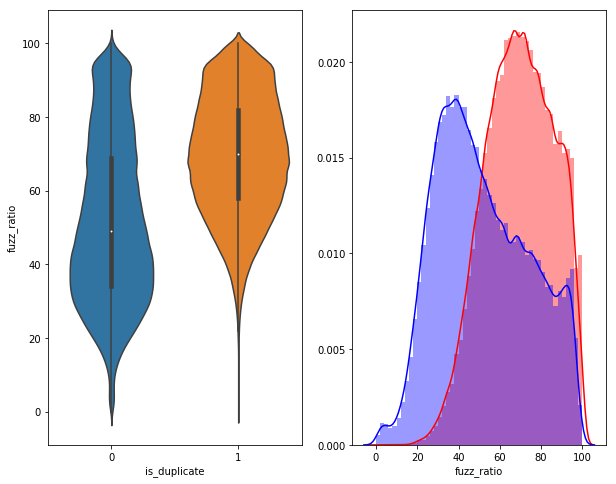

In [33]:
plt.figure(figsize=(10, 8))

plt.subplot(1,2,1)
sns.violinplot(x = 'is_duplicate', y = 'fuzz_ratio', data = df[0:] , )

plt.subplot(1,2,2)
sns.distplot(df[df['is_duplicate'] == 1.0]['fuzz_ratio'][0:] , label = "1", color = 'red')
sns.distplot(df[df['is_duplicate'] == 0.0]['fuzz_ratio'][0:] , label = "0" , color = 'blue' )
plt.show()

In [34]:
# Using TSNE for Dimentionality reduction for 15 Features(Generated after cleaning the data) to 3 dimention

from sklearn.preprocessing import MinMaxScaler

dfp_subsampled = df[0:5000]
X = MinMaxScaler().fit_transform(dfp_subsampled[['cwc_min', 'cwc_max', 'csc_min', 'csc_max' , 'ctc_min' , 'ctc_max' , 'last_word_eq', 'first_word_eq' , 'abs_len_diff' , 'mean_len' , 'token_set_ratio' , 'token_sort_ratio' ,  'fuzz_ratio' , 'fuzz_partial_ratio' , 'longest_substr_ratio']])
y = dfp_subsampled['is_duplicate'].values

In [35]:
tsne2d = TSNE(
    n_components=2,
    init='random', # pca
    random_state=101,
    method='barnes_hut',
    n_iter=1000,
    verbose=2,
    angle=0.5
).fit_transform(X)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 5000 samples in 0.021s...
[t-SNE] Computed neighbors for 5000 samples in 0.419s...
[t-SNE] Computed conditional probabilities for sample 1000 / 5000
[t-SNE] Computed conditional probabilities for sample 2000 / 5000
[t-SNE] Computed conditional probabilities for sample 3000 / 5000
[t-SNE] Computed conditional probabilities for sample 4000 / 5000
[t-SNE] Computed conditional probabilities for sample 5000 / 5000
[t-SNE] Mean sigma: 0.130446
[t-SNE] Computed conditional probabilities in 0.196s
[t-SNE] Iteration 50: error = 81.2897949, gradient norm = 0.0455700 (50 iterations in 8.376s)
[t-SNE] Iteration 100: error = 70.6164398, gradient norm = 0.0095177 (50 iterations in 7.228s)
[t-SNE] Iteration 150: error = 68.9172134, gradient norm = 0.0056736 (50 iterations in 7.206s)
[t-SNE] Iteration 200: error = 68.1004639, gradient norm = 0.0049672 (50 iterations in 6.733s)
[t-SNE] Iteration 250: error = 67.5914536, gradient norm = 0.0039700

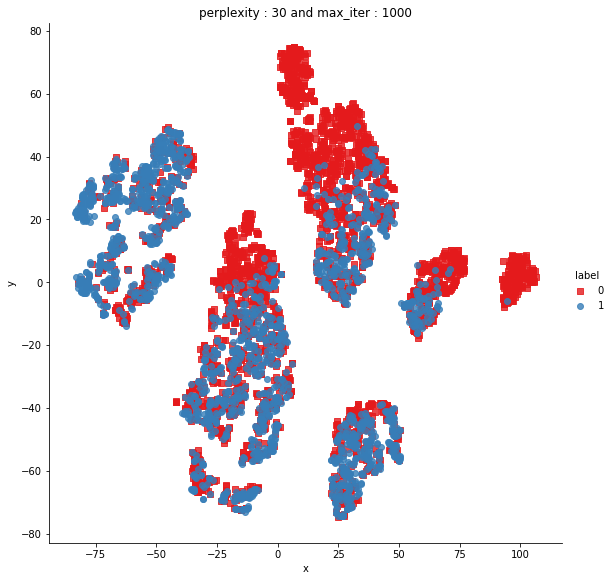

In [36]:
df = pd.DataFrame({'x':tsne2d[:,0], 'y':tsne2d[:,1] ,'label':y})

# draw the plot in appropriate place in the grid
sns.lmplot(data=df, x='x', y='y', hue='label', fit_reg=False, size=8,palette="Set1",markers=['s','o'])
plt.title("perplexity : {} and max_iter : {}".format(30, 1000))
plt.show()

In [37]:
from sklearn.manifold import TSNE
tsne3d = TSNE(
    n_components=3,
    init='random', # pca
    random_state=101,
    method='barnes_hut',
    n_iter=1000,
    verbose=2,
    angle=0.5
).fit_transform(X)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 5000 samples in 0.017s...
[t-SNE] Computed neighbors for 5000 samples in 0.372s...
[t-SNE] Computed conditional probabilities for sample 1000 / 5000
[t-SNE] Computed conditional probabilities for sample 2000 / 5000
[t-SNE] Computed conditional probabilities for sample 3000 / 5000
[t-SNE] Computed conditional probabilities for sample 4000 / 5000
[t-SNE] Computed conditional probabilities for sample 5000 / 5000
[t-SNE] Mean sigma: 0.130446
[t-SNE] Computed conditional probabilities in 0.158s
[t-SNE] Iteration 50: error = 80.5298615, gradient norm = 0.0306586 (50 iterations in 13.145s)
[t-SNE] Iteration 100: error = 69.3777008, gradient norm = 0.0037944 (50 iterations in 6.821s)
[t-SNE] Iteration 150: error = 67.9726028, gradient norm = 0.0017517 (50 iterations in 6.384s)
[t-SNE] Iteration 200: error = 67.4098892, gradient norm = 0.0013384 (50 iterations in 6.431s)
[t-SNE] Iteration 250: error = 67.0977859, gradient norm = 0.000959

In [38]:
trace1 = go.Scatter3d(
    x=tsne3d[:,0],
    y=tsne3d[:,1],
    z=tsne3d[:,2],
    mode='markers',
    marker=dict(
        sizemode='diameter',
        color = y,
        colorscale = 'Portland',
        colorbar = dict(title = 'duplicate'),
        line=dict(color='rgb(255, 255, 255)'),
        opacity=0.75
    )
)

data=[trace1]
layout=dict(height=800, width=800, title='3d embedding with engineered features')
fig=dict(data=data, layout=layout)
py.iplot(fig, filename='3DBubble')

In [39]:
#Read the final_features data frame
df_nlp = pd.read_csv("nlp_features_train.csv",encoding='latin-1')
df_ppro = pd.read_csv("df_fe_without_preprocessing_train.csv",encoding='latin-1')

In [40]:
df_nlp.head(2)

id  qid1  qid2                                          question1  \
0   0     1     2  what is the step by step guide to invest in sh...   
1   1     3     4  what is the story of kohinoor  koh i noor  dia...   

                                           question2  is_duplicate   cwc_min  \
0  what is the step by step guide to invest in sh...             0  0.999980   
1  what would happen if the indian government sto...             0  0.799984   

    cwc_max   csc_min   csc_max          ...            ctc_max  last_word_eq  \
0  0.833319  0.999983  0.999983          ...           0.785709           0.0   
1  0.399996  0.749981  0.599988          ...           0.466664           0.0   

   first_word_eq  abs_len_diff  mean_len  token_set_ratio  token_sort_ratio  \
0            1.0           2.0      13.0              100                93   
1            1.0           5.0      12.5               86                63   

   fuzz_ratio  fuzz_partial_ratio  longest_substr_ratio  
0          93                 100              0.982759  
1          66                  75              0.596154  

[2 rows x 21 columns]

In [41]:
df_ppro.head(2)

id  qid1  qid2                                          question1  \
0   0     1     2  What is the step by step guide to invest in sh...   
1   1     3     4  What is the story of Kohinoor (Koh-i-Noor) Dia...   

                                           question2  is_duplicate  freq_qid1  \
0  What is the step by step guide to invest in sh...             0          1   
1  What would happen if the Indian government sto...             0          4   

   freq_qid2  q1len  q2len  q1_n_words  q2_n_words  word_Common  word_Total  \
0          1     66     57          14          12         10.0        23.0   
1          1     51     88           8          13          4.0        20.0   

   word_share  freq_q1+q2  freq_q1-q2  
0    0.434783           2           0  
1    0.200000           5           3

In [42]:
df_ppro.shape

(404290, 17)

In [43]:
df1 = df_nlp.drop(['qid1','qid2'],axis=1)
df2 = df_ppro.drop(['qid1','qid2','question1','question2','is_duplicate'],axis=1)

df  = df1.merge(df2, on='id',how='left')

In [44]:
df.head()

id                                          question1  \
0   0  what is the step by step guide to invest in sh...   
1   1  what is the story of kohinoor  koh i noor  dia...   
2   2  how can i increase the speed of my internet co...   
3   3  why am i mentally very lonely  how can i solve...   
4   4  which one dissolve in water quikly sugar  salt...   

                                           question2  is_duplicate   cwc_min  \
0  what is the step by step guide to invest in sh...             0  0.999980   
1  what would happen if the indian government sto...             0  0.799984   
2  how can internet speed be increased by hacking...             0  0.399992   
3  find the remainder when  math 23  24   math  i...             0  0.000000   
4            which fish would survive in salt water              0  0.399992   

    cwc_max   csc_min   csc_max   ctc_min   ctc_max     ...      freq_qid2  \
0  0.833319  0.999983  0.999983  0.916659  0.785709     ...              1   
1  0.399996  0.749981  0.599988  0.699993  0.466664     ...              1   
2  0.333328  0.399992  0.249997  0.399996  0.285712     ...              1   
3  0.000000  0.000000  0.000000  0.000000  0.000000     ...              1   
4  0.199998  0.999950  0.666644  0.571420  0.307690     ...              1   

   q1len  q2len  q1_n_words  q2_n_words  word_Common  word_Total  word_share  \
0     66     57          14          12         10.0        23.0    0.434783   
1     51     88           8          13          4.0        20.0    0.200000   
2     73     59          14          10          4.0        24.0    0.166667   
3     50     65          11           9          0.0        19.0    0.000000   
4     76     39          13           7          2.0        20.0    0.100000   

   freq_q1+q2  freq_q1-q2  
0           2           0  
1           5           3  
2           2           0  
3           2           0  
4           4           2  

[5 rows x 30 columns]

In [45]:
df.columns

Index(['id', 'question1', 'question2', 'is_duplicate', 'cwc_min', 'cwc_max',
       'csc_min', 'csc_max', 'ctc_min', 'ctc_max', 'last_word_eq',
       'first_word_eq', 'abs_len_diff', 'mean_len', 'token_set_ratio',
       'token_sort_ratio', 'fuzz_ratio', 'fuzz_partial_ratio',
       'longest_substr_ratio', 'freq_qid1', 'freq_qid2', 'q1len', 'q2len',
       'q1_n_words', 'q2_n_words', 'word_Common', 'word_Total', 'word_share',
       'freq_q1+q2', 'freq_q1-q2'],
      dtype='object')

In [46]:
#Remove the first row 
#data.drop(data.index[0], inplace=True)
y_true = df['is_duplicate']
df.drop(['id','is_duplicate'], axis=1, inplace=True)


In [47]:
df.shape

(404290, 28)

In [48]:
X_train,X_test, y_train, y_test = train_test_split(df, y_true, stratify=y_true, test_size=0.3)

In [49]:
print("Number of data points in train data :",X_train.shape)
print("Number of data points in test data :",X_test.shape)

Number of data points in train data : (283003, 28)
Number of data points in test data : (121287, 28)


In [50]:
print("-"*10, "Distribution of output variable in train data", "-"*10)
train_distr = Counter(y_train)
train_len = len(y_train)
print("Class 0: ",int(train_distr[0])/train_len,"Class 1: ", int(train_distr[1])/train_len)
print("-"*10, "Distribution of output variable in train data", "-"*10)
test_distr = Counter(y_test)
test_len = len(y_test)
print("Class 0: ",int(test_distr[1])/test_len, "Class 1: ",int(test_distr[1])/test_len)

---------- Distribution of output variable in train data ----------
Class 0:  0.6308025003268517 Class 1:  0.36919749967314835
---------- Distribution of output variable in train data ----------
Class 0:  0.3691986775169639 Class 1:  0.3691986775169639


In [51]:
#Tfidf Vectorizer for Question-1
tfidf_vect1 = TfidfVectorizer()

train_q1_tfidf = tfidf_vect1.fit_transform(X_train['question1'].values.astype('U'))
test_q1_tfidf = tfidf_vect1.transform(X_test['question1'].values.astype('U'))

In [52]:
print(train_q1_tfidf.shape)
print(test_q1_tfidf.shape)

(283003, 58298)
(121287, 58298)


In [53]:
#Tfidf Vectorizer for Question-2
tfidf_vect2 = TfidfVectorizer()

train_q2_tfidf = tfidf_vect2.fit_transform(X_train['question2'].values.astype('U'))
test_q2_tfidf = tfidf_vect2.transform(X_test['question2'].values.astype('U'))

In [54]:
print(train_q2_tfidf.shape)
print(test_q2_tfidf.shape)

(283003, 53794)
(121287, 53794)


In [55]:
#Combining Question-1 and Question-2
train_tfidf = hstack((train_q1_tfidf,train_q2_tfidf))
test_tfidf = hstack((test_q1_tfidf,test_q2_tfidf))

In [56]:
#Dropping question-1 and question-2 and Replacing with tfidf values
X_train.drop(['question1','question2'], axis=1, inplace=True)
X_test.drop(['question1','question2'], axis=1, inplace=True)

In [57]:
#Combining all train nlp features, adv features and tfidf features
X_train = hstack((X_train, train_tfidf)).tocsr()

In [58]:
#Combining all test nlp features, adv features and tfidf features
X_test = hstack((X_test, test_tfidf)).tocsr()

In [59]:
print(X_train.shape)
print(X_test.shape)

(283003, 112118)
(121287, 112118)


In [60]:
# This function plots the confusion matrices given y_i, y_i_hat.
def plot_confusion_matrix(test_y, predict_y):
    C = confusion_matrix(test_y, predict_y)
    # C = 9,9 matrix, each cell (i,j) represents number of points of class i are predicted class j
    
    A =(((C.T)/(C.sum(axis=1))).T)
    #divid each element of the confusion matrix with the sum of elements in that column
    
    # C = [[1, 2],
    #     [3, 4]]
    # C.T = [[1, 3],
    #        [2, 4]]
    # C.sum(axis = 1)  axis=0 corresonds to columns and axis=1 corresponds to rows in two diamensional array
    # C.sum(axix =1) = [[3, 7]]
    # ((C.T)/(C.sum(axis=1))) = [[1/3, 3/7]
    #                           [2/3, 4/7]]

    # ((C.T)/(C.sum(axis=1))).T = [[1/3, 2/3]
    #                           [3/7, 4/7]]
    # sum of row elements = 1
    
    B =(C/C.sum(axis=0))
    #divid each element of the confusion matrix with the sum of elements in that row
    # C = [[1, 2],
    #     [3, 4]]
    # C.sum(axis = 0)  axis=0 corresonds to columns and axis=1 corresponds to rows in two diamensional array
    # C.sum(axix =0) = [[4, 6]]
    # (C/C.sum(axis=0)) = [[1/4, 2/6],
    #                      [3/4, 4/6]] 
    plt.figure(figsize=(20,4))
    
    labels = [1,2]
    # representing A in heatmap format
    cmap=sns.light_palette("blue")
    plt.subplot(1, 3, 1)
    sns.heatmap(C, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Confusion matrix")
    plt.subplot(1, 3, 2)
    sns.heatmap(B, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Precision matrix")
    
    plt.subplot(1, 3, 3)
    # representing B in heatmap format
    sns.heatmap(A, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Recall matrix")
    
    plt.show()

## Building a random model

Log loss on Test Data using Random Model 0.8847826150025462


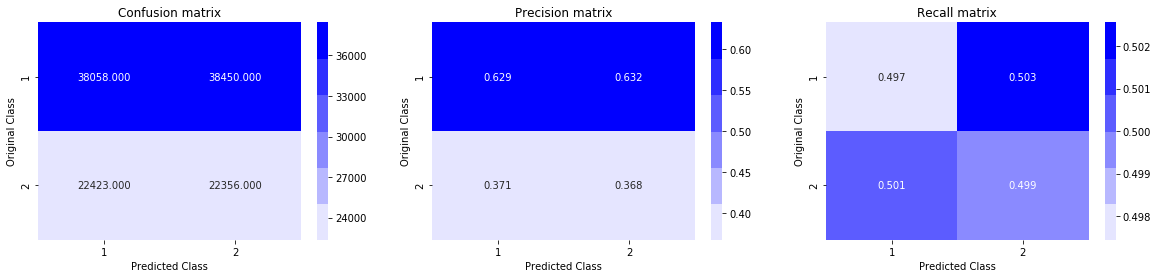

In [61]:
# we need to generate 9 numbers and the sum of numbers should be 1
# one solution is to genarate 9 numbers and divide each of the numbers by their sum
# ref: https://stackoverflow.com/a/18662466/4084039
# we create a output array that has exactly same size as the CV data
predicted_y = np.zeros((test_len,2))
for i in range(test_len):
    rand_probs = np.random.rand(1,2)
    predicted_y[i] = ((rand_probs/sum(sum(rand_probs)))[0])
print("Log loss on Test Data using Random Model",log_loss(y_test, predicted_y, eps=1e-15))

predicted_y =np.argmax(predicted_y, axis=1)
plot_confusion_matrix(y_test, predicted_y)

## Task-1 
### Logistic Regression with TFIDF Vectorizer, hyperparameter tuning

For values of alpha =  1e-05 The log loss is: 0.4470388226690458
For values of alpha =  0.0001 The log loss is: 0.4419376198629939
For values of alpha =  0.001 The log loss is: 0.4448728010381185
For values of alpha =  0.01 The log loss is: 0.44482839231214194
For values of alpha =  0.1 The log loss is: 0.4580330553604704
For values of alpha =  1 The log loss is: 0.492360415142074
For values of alpha =  10 The log loss is: 0.5422302999384843


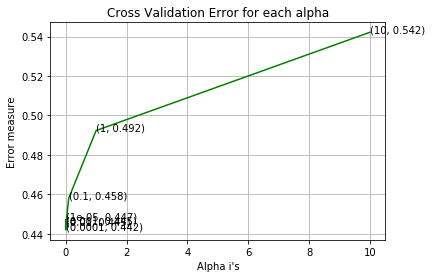

For values of best alpha =  0.0001 The train log loss is: 0.4426720466462092
For values of best alpha =  0.0001 The test log loss is: 0.4419376198629939
Total number of data points : 121287


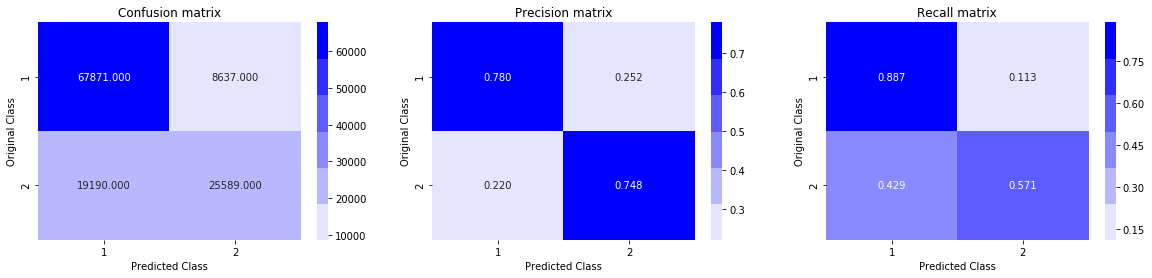

In [62]:
from sklearn.linear_model import SGDClassifier
alpha = [10 ** x for x in range(-5, 2)] # hyperparam for SGD classifier.

# read more about SGDClassifier() at http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html
# ------------------------------
# default parameters
# SGDClassifier(loss=’hinge’, penalty=’l2’, alpha=0.0001, l1_ratio=0.15, fit_intercept=True, max_iter=None, tol=None, 
# shuffle=True, verbose=0, epsilon=0.1, n_jobs=1, random_state=None, learning_rate=’optimal’, eta0=0.0, power_t=0.5, 
# class_weight=None, warm_start=False, average=False, n_iter=None)

# some of methods
# fit(X, y[, coef_init, intercept_init, …])	Fit linear model with Stochastic Gradient Descent.
# predict(X)	Predict class labels for samples in X.

#-------------------------------
# video link: 
#------------------------------


log_error_array=[]
for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l2', loss='log', random_state=42)
    clf.fit(X_train, y_train)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(X_train, y_train)
    predict_y = sig_clf.predict_proba(X_test)
    log_error_array.append(log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
    print('For values of alpha = ', i, "The log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

fig, ax = plt.subplots()
ax.plot(alpha, log_error_array,c='g')
for i, txt in enumerate(np.round(log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(X_train, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(X_train, y_train)

predict_y = sig_clf.predict_proba(X_train)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(X_test)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
predicted_y =np.argmax(predict_y,axis=1)
print("Total number of data points :", len(predicted_y))
plot_confusion_matrix(y_test, predicted_y)

### Linear SVM with TFIDF Vectorizer, hyperparameter tuning

For values of alpha =  1e-05 The log loss is: 0.45246587116474035
For values of alpha =  0.0001 The log loss is: 0.47355504215853855
For values of alpha =  0.001 The log loss is: 0.5048115629959221
For values of alpha =  0.01 The log loss is: 0.5224531476120399
For values of alpha =  0.1 The log loss is: 0.5031188670448494
For values of alpha =  1 The log loss is: 0.5649078902453422
For values of alpha =  10 The log loss is: 0.6454860331814661


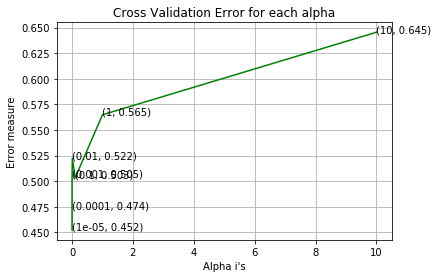

For values of best alpha =  1e-05 The train log loss is: 0.452262202914474
For values of best alpha =  1e-05 The test log loss is: 0.45246587116474035
Total number of data points : 121287


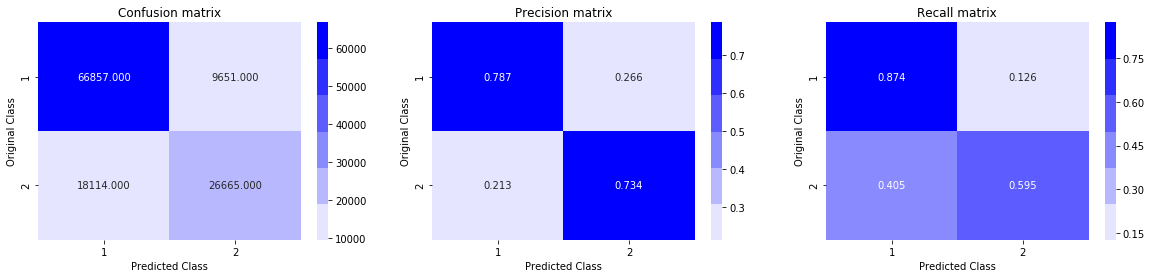

In [63]:
alpha = [10 ** x for x in range(-5, 2)] # hyperparam for SGD classifier.

# read more about SGDClassifier() at http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html
# ------------------------------
# default parameters
# SGDClassifier(loss=’hinge’, penalty=’l2’, alpha=0.0001, l1_ratio=0.15, fit_intercept=True, max_iter=None, tol=None, 
# shuffle=True, verbose=0, epsilon=0.1, n_jobs=1, random_state=None, learning_rate=’optimal’, eta0=0.0, power_t=0.5, 
# class_weight=None, warm_start=False, average=False, n_iter=None)

# some of methods
# fit(X, y[, coef_init, intercept_init, …])	Fit linear model with Stochastic Gradient Descent.
# predict(X)	Predict class labels for samples in X.

#-------------------------------
# video link: 
#------------------------------


log_error_array=[]
for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l1', loss='hinge', random_state=42)
    clf.fit(X_train, y_train)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(X_train, y_train)
    predict_y = sig_clf.predict_proba(X_test)
    log_error_array.append(log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
    print('For values of alpha = ', i, "The log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

fig, ax = plt.subplots()
ax.plot(alpha, log_error_array,c='g')
for i, txt in enumerate(np.round(log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()
best_alpha = np.argmin(log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l1', loss='hinge', random_state=42)
clf.fit(X_train, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(X_train, y_train)

predict_y = sig_clf.predict_proba(X_train)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(X_test)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
predicted_y =np.argmax(predict_y,axis=1)
print("Total number of data points :", len(predicted_y))
plot_confusion_matrix(y_test, predicted_y)

## XGBoost

In [64]:
import xgboost as xgb
params = {}
params['objective'] = 'binary:logistic'
params['eval_metric'] = 'logloss'
params['eta'] = 0.02
params['max_depth'] = 4

d_train = xgb.DMatrix(X_train, label=y_train)
d_test = xgb.DMatrix(X_test, label=y_test)

watchlist = [(d_train, 'train'), (d_test, 'valid')]

bst = xgb.train(params, d_train, 400, watchlist, early_stopping_rounds=20, verbose_eval=10)

xgdmat = xgb.DMatrix(X_train,y_train)
predict_y = bst.predict(d_test)
print("The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

[0]	train-logloss:0.684214	valid-logloss:0.684644
Multiple eval metrics have been passed: 'valid-logloss' will be used for early stopping.

Will train until valid-logloss hasn't improved in 20 rounds.
[10]	train-logloss:0.615572	valid-logloss:0.615413
[20]	train-logloss:0.564652	valid-logloss:0.565127
[30]	train-logloss:0.525772	valid-logloss:0.526839
[40]	train-logloss:0.49662	valid-logloss:0.4975
[50]	train-logloss:0.473693	valid-logloss:0.474454
[60]	train-logloss:0.455532	valid-logloss:0.456175
[70]	train-logloss:0.44104	valid-logloss:0.441815
[80]	train-logloss:0.42867	valid-logloss:0.429861
[90]	train-logloss:0.419157	valid-logloss:0.42035
[100]	train-logloss:0.411351	valid-logloss:0.412447
[110]	train-logloss:0.404309	valid-logloss:0.40552
[120]	train-logloss:0.398858	valid-logloss:0.400084
[130]	train-logloss:0.394318	valid-logloss:0.395443
[140]	train-logloss:0.390279	valid-logloss:0.391434
[150]	train-logloss:0.386578	valid-logloss:0.38782
[160]	train-logloss:0.38376	valid-lo

Total number of data points : 121287


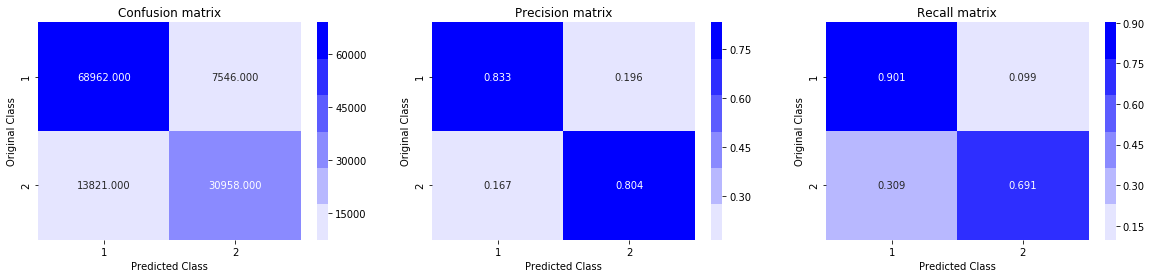

In [65]:
predicted_y =np.array(predict_y>0.5,dtype=int)
print("Total number of data points :", len(predicted_y))
plot_confusion_matrix(y_test, predicted_y)

## Task 2
### XGboost with TFIDF Vecotorizer using RanomizedSearchCV

In [66]:
from sklearn.model_selection import RandomizedSearchCV
import scipy.stats as st

In [67]:
param_grid = {
        'silent': [False],
        'max_depth': [4],
        'learning_rate': [0.001, 0.01, 0.1, 0.2, 0,3],
        'subsample': [0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
        'colsample_bytree': [0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
        'colsample_bylevel': [0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
        'min_child_weight': [0.5, 1.0, 3.0, 5.0, 7.0, 10.0],
        'gamma': [0, 0.25, 0.5, 1.0],
        'reg_lambda': [0.1, 1.0, 5.0, 10.0, 50.0, 100.0],
        'n_estimators': [100]}
fit_params = {'eval_metric': 'logloss',
              'early_stopping_rounds': 10,
              'eval_set': [(X_train, y_train)]
              }

clf = xgb.XGBClassifier()

In [68]:
rs_clf = RandomizedSearchCV(clf, param_grid, n_iter=20,
                            n_jobs=1, verbose=0, cv=2,
                            fit_params=fit_params,
                            scoring='neg_log_loss', refit=False, random_state=42)

In [69]:
rs_clf.fit(X_train, y_train)

[0]	validation_0-logloss:0.691684
Will train until validation_0-logloss hasn't improved in 10 rounds.
[1]	validation_0-logloss:0.691164
[2]	validation_0-logloss:0.690552
[3]	validation_0-logloss:0.690312
[4]	validation_0-logloss:0.690067
[5]	validation_0-logloss:0.689963
[6]	validation_0-logloss:0.689845
[7]	validation_0-logloss:0.689662
[8]	validation_0-logloss:0.689486
[9]	validation_0-logloss:0.689329
[10]	validation_0-logloss:0.688834
[11]	validation_0-logloss:0.688662
[12]	validation_0-logloss:0.688275
[13]	validation_0-logloss:0.68818
[14]	validation_0-logloss:0.687207
[15]	validation_0-logloss:0.686886
[16]	validation_0-logloss:0.68657
[17]	validation_0-logloss:0.686148
[18]	validation_0-logloss:0.685446
[19]	validation_0-logloss:0.685148
[20]	validation_0-logloss:0.684801
[21]	validation_0-logloss:0.684521
[22]	validation_0-logloss:0.684287
[23]	validation_0-logloss:0.684097
[24]	validation_0-logloss:0.68371
[25]	validation_0-logloss:0.68351
[26]	validation_0-logloss:0.682911
[

[31]	validation_0-logloss:0.597726
[32]	validation_0-logloss:0.595651
[33]	validation_0-logloss:0.593085
[34]	validation_0-logloss:0.590532
[35]	validation_0-logloss:0.588424
[36]	validation_0-logloss:0.586753
[37]	validation_0-logloss:0.58455
[38]	validation_0-logloss:0.582397
[39]	validation_0-logloss:0.580217
[40]	validation_0-logloss:0.578199
[41]	validation_0-logloss:0.575913
[42]	validation_0-logloss:0.573758
[43]	validation_0-logloss:0.571637
[44]	validation_0-logloss:0.5705
[45]	validation_0-logloss:0.569089
[46]	validation_0-logloss:0.567158
[47]	validation_0-logloss:0.565239
[48]	validation_0-logloss:0.563237
[49]	validation_0-logloss:0.561456
[50]	validation_0-logloss:0.56016
[51]	validation_0-logloss:0.558443
[52]	validation_0-logloss:0.556582
[53]	validation_0-logloss:0.55465
[54]	validation_0-logloss:0.55284
[55]	validation_0-logloss:0.551246
[56]	validation_0-logloss:0.549298
[57]	validation_0-logloss:0.547914
[58]	validation_0-logloss:0.546187
[59]	validation_0-logloss:

[35]	validation_0-logloss:0.678852
[36]	validation_0-logloss:0.67842
[37]	validation_0-logloss:0.678031
[38]	validation_0-logloss:0.67782
[39]	validation_0-logloss:0.677544
[40]	validation_0-logloss:0.677349
[41]	validation_0-logloss:0.677023
[42]	validation_0-logloss:0.676631
[43]	validation_0-logloss:0.676008
[44]	validation_0-logloss:0.675714
[45]	validation_0-logloss:0.675339
[46]	validation_0-logloss:0.675095
[47]	validation_0-logloss:0.674221
[48]	validation_0-logloss:0.673918
[49]	validation_0-logloss:0.67358
[50]	validation_0-logloss:0.673362
[51]	validation_0-logloss:0.672817
[52]	validation_0-logloss:0.672404
[53]	validation_0-logloss:0.672119
[54]	validation_0-logloss:0.671774
[55]	validation_0-logloss:0.671529
[56]	validation_0-logloss:0.671313
[57]	validation_0-logloss:0.670888
[58]	validation_0-logloss:0.670543
[59]	validation_0-logloss:0.670289
[60]	validation_0-logloss:0.669664
[61]	validation_0-logloss:0.66939
[62]	validation_0-logloss:0.66894
[63]	validation_0-logloss

[67]	validation_0-logloss:0.365394
[68]	validation_0-logloss:0.364843
[69]	validation_0-logloss:0.36445
[70]	validation_0-logloss:0.364078
[71]	validation_0-logloss:0.363601
[72]	validation_0-logloss:0.36328
[73]	validation_0-logloss:0.362744
[74]	validation_0-logloss:0.362528
[75]	validation_0-logloss:0.362139
[76]	validation_0-logloss:0.361902
[77]	validation_0-logloss:0.36144
[78]	validation_0-logloss:0.360933
[79]	validation_0-logloss:0.360451
[80]	validation_0-logloss:0.360241
[81]	validation_0-logloss:0.360028
[82]	validation_0-logloss:0.359863
[83]	validation_0-logloss:0.359566
[84]	validation_0-logloss:0.359156
[85]	validation_0-logloss:0.35891
[86]	validation_0-logloss:0.358732
[87]	validation_0-logloss:0.358554
[88]	validation_0-logloss:0.358293
[89]	validation_0-logloss:0.357858
[90]	validation_0-logloss:0.357665
[91]	validation_0-logloss:0.35749
[92]	validation_0-logloss:0.357138
[93]	validation_0-logloss:0.356797
[94]	validation_0-logloss:0.356635
[95]	validation_0-logloss

[99]	validation_0-logloss:0.659568
[0]	validation_0-logloss:0.691661
Will train until validation_0-logloss hasn't improved in 10 rounds.
[1]	validation_0-logloss:0.691157
[2]	validation_0-logloss:0.69071
[3]	validation_0-logloss:0.690297
[4]	validation_0-logloss:0.690194
[5]	validation_0-logloss:0.690016
[6]	validation_0-logloss:0.689932
[7]	validation_0-logloss:0.689766
[8]	validation_0-logloss:0.68962
[9]	validation_0-logloss:0.689251
[10]	validation_0-logloss:0.68895
[11]	validation_0-logloss:0.688717
[12]	validation_0-logloss:0.688598
[13]	validation_0-logloss:0.68783
[14]	validation_0-logloss:0.687321
[15]	validation_0-logloss:0.686967
[16]	validation_0-logloss:0.686634
[17]	validation_0-logloss:0.686218
[18]	validation_0-logloss:0.685864
[19]	validation_0-logloss:0.685636
[20]	validation_0-logloss:0.685159
[21]	validation_0-logloss:0.684912
[22]	validation_0-logloss:0.684644
[23]	validation_0-logloss:0.684421
[24]	validation_0-logloss:0.684232
[25]	validation_0-logloss:0.683994
[

[30]	validation_0-logloss:0.387361
[31]	validation_0-logloss:0.386133
[32]	validation_0-logloss:0.38499
[33]	validation_0-logloss:0.383954
[34]	validation_0-logloss:0.38254
[35]	validation_0-logloss:0.381325
[36]	validation_0-logloss:0.38032
[37]	validation_0-logloss:0.379601
[38]	validation_0-logloss:0.378631
[39]	validation_0-logloss:0.377961
[40]	validation_0-logloss:0.377029
[41]	validation_0-logloss:0.376224
[42]	validation_0-logloss:0.375253
[43]	validation_0-logloss:0.374607
[44]	validation_0-logloss:0.373933
[45]	validation_0-logloss:0.373413
[46]	validation_0-logloss:0.372573
[47]	validation_0-logloss:0.372079
[48]	validation_0-logloss:0.371265
[49]	validation_0-logloss:0.370279
[50]	validation_0-logloss:0.369901
[51]	validation_0-logloss:0.369507
[52]	validation_0-logloss:0.36873
[53]	validation_0-logloss:0.368071
[54]	validation_0-logloss:0.36717
[55]	validation_0-logloss:0.366398
[56]	validation_0-logloss:0.365609
[57]	validation_0-logloss:0.364761
[58]	validation_0-logloss

[62]	validation_0-logloss:0.362787
[63]	validation_0-logloss:0.362498
[64]	validation_0-logloss:0.362032
[65]	validation_0-logloss:0.361556
[66]	validation_0-logloss:0.360774
[67]	validation_0-logloss:0.360277
[68]	validation_0-logloss:0.36002
[69]	validation_0-logloss:0.359359
[70]	validation_0-logloss:0.358968
[71]	validation_0-logloss:0.358752
[72]	validation_0-logloss:0.358322
[73]	validation_0-logloss:0.357705
[74]	validation_0-logloss:0.357463
[75]	validation_0-logloss:0.357033
[76]	validation_0-logloss:0.356713
[77]	validation_0-logloss:0.356461
[78]	validation_0-logloss:0.356136
[79]	validation_0-logloss:0.355852
[80]	validation_0-logloss:0.355574
[81]	validation_0-logloss:0.355183
[82]	validation_0-logloss:0.354999
[83]	validation_0-logloss:0.354775
[84]	validation_0-logloss:0.353969
[85]	validation_0-logloss:0.353687
[86]	validation_0-logloss:0.35328
[87]	validation_0-logloss:0.353025
[88]	validation_0-logloss:0.352628
[89]	validation_0-logloss:0.352356
[90]	validation_0-logl

[9]	validation_0-logloss:0.413598
[10]	validation_0-logloss:0.406908
[11]	validation_0-logloss:0.401375
[12]	validation_0-logloss:0.396482
[13]	validation_0-logloss:0.393045
[14]	validation_0-logloss:0.390025
[15]	validation_0-logloss:0.386857
[16]	validation_0-logloss:0.384372
[17]	validation_0-logloss:0.382386
[18]	validation_0-logloss:0.379781
[19]	validation_0-logloss:0.377517
[20]	validation_0-logloss:0.375699
[21]	validation_0-logloss:0.37378
[22]	validation_0-logloss:0.372443
[23]	validation_0-logloss:0.370513
[24]	validation_0-logloss:0.369569
[25]	validation_0-logloss:0.36843
[26]	validation_0-logloss:0.366919
[27]	validation_0-logloss:0.36542
[28]	validation_0-logloss:0.364738
[29]	validation_0-logloss:0.364074
[30]	validation_0-logloss:0.363069
[31]	validation_0-logloss:0.362478
[32]	validation_0-logloss:0.361476
[33]	validation_0-logloss:0.360394
[34]	validation_0-logloss:0.359859
[35]	validation_0-logloss:0.359361
[36]	validation_0-logloss:0.358973
[37]	validation_0-loglos

[13]	validation_0-logloss:0.44424
[14]	validation_0-logloss:0.438117
[15]	validation_0-logloss:0.431811
[16]	validation_0-logloss:0.426894
[17]	validation_0-logloss:0.421679
[18]	validation_0-logloss:0.417442
[19]	validation_0-logloss:0.413207
[20]	validation_0-logloss:0.409074
[21]	validation_0-logloss:0.405597
[22]	validation_0-logloss:0.402623
[23]	validation_0-logloss:0.40011
[24]	validation_0-logloss:0.397913
[25]	validation_0-logloss:0.395764
[26]	validation_0-logloss:0.39363
[27]	validation_0-logloss:0.391434
[28]	validation_0-logloss:0.389764
[29]	validation_0-logloss:0.38803
[30]	validation_0-logloss:0.386031
[31]	validation_0-logloss:0.384727
[32]	validation_0-logloss:0.382936
[33]	validation_0-logloss:0.381437
[34]	validation_0-logloss:0.380455
[35]	validation_0-logloss:0.379588
[36]	validation_0-logloss:0.378442
[37]	validation_0-logloss:0.377061
[38]	validation_0-logloss:0.376058
[39]	validation_0-logloss:0.375397
[40]	validation_0-logloss:0.374459
[41]	validation_0-loglos

[45]	validation_0-logloss:0.559326
[46]	validation_0-logloss:0.556781
[47]	validation_0-logloss:0.554856
[48]	validation_0-logloss:0.553181
[49]	validation_0-logloss:0.551136
[50]	validation_0-logloss:0.549303
[51]	validation_0-logloss:0.547288
[52]	validation_0-logloss:0.54592
[53]	validation_0-logloss:0.544057
[54]	validation_0-logloss:0.542369
[55]	validation_0-logloss:0.540428
[56]	validation_0-logloss:0.538858
[57]	validation_0-logloss:0.536892
[58]	validation_0-logloss:0.534913
[59]	validation_0-logloss:0.533246
[60]	validation_0-logloss:0.531619
[61]	validation_0-logloss:0.529762
[62]	validation_0-logloss:0.52812
[63]	validation_0-logloss:0.526306
[64]	validation_0-logloss:0.525059
[65]	validation_0-logloss:0.523162
[66]	validation_0-logloss:0.521681
[67]	validation_0-logloss:0.519756
[68]	validation_0-logloss:0.51839
[69]	validation_0-logloss:0.517415
[70]	validation_0-logloss:0.515531
[71]	validation_0-logloss:0.514281
[72]	validation_0-logloss:0.5125
[73]	validation_0-logloss

[77]	validation_0-logloss:0.344114
[78]	validation_0-logloss:0.343862
[79]	validation_0-logloss:0.343495
[80]	validation_0-logloss:0.343139
[81]	validation_0-logloss:0.342912
[82]	validation_0-logloss:0.34273
[83]	validation_0-logloss:0.342494
[84]	validation_0-logloss:0.342289
[85]	validation_0-logloss:0.341991
[86]	validation_0-logloss:0.34186
[87]	validation_0-logloss:0.341605
[88]	validation_0-logloss:0.341406
[89]	validation_0-logloss:0.341016
[90]	validation_0-logloss:0.340807
[91]	validation_0-logloss:0.340692
[92]	validation_0-logloss:0.340554
[93]	validation_0-logloss:0.340171
[94]	validation_0-logloss:0.339804
[95]	validation_0-logloss:0.339636
[96]	validation_0-logloss:0.339502
[97]	validation_0-logloss:0.339279
[98]	validation_0-logloss:0.339151
[99]	validation_0-logloss:0.339043
[0]	validation_0-logloss:0.659568
Will train until validation_0-logloss hasn't improved in 10 rounds.
[1]	validation_0-logloss:0.627485
[2]	validation_0-logloss:0.598759
[3]	validation_0-logloss:0.

[8]	validation_0-logloss:0.69173
[9]	validation_0-logloss:0.69173
[10]	validation_0-logloss:0.69173
Stopping. Best iteration:
[0]	validation_0-logloss:0.69173

[0]	validation_0-logloss:0.69173
Will train until validation_0-logloss hasn't improved in 10 rounds.
[1]	validation_0-logloss:0.69173
[2]	validation_0-logloss:0.69173
[3]	validation_0-logloss:0.69173
[4]	validation_0-logloss:0.69173
[5]	validation_0-logloss:0.69173
[6]	validation_0-logloss:0.69173
[7]	validation_0-logloss:0.69173
[8]	validation_0-logloss:0.69173
[9]	validation_0-logloss:0.69173
[10]	validation_0-logloss:0.69173
Stopping. Best iteration:
[0]	validation_0-logloss:0.69173

[0]	validation_0-logloss:0.507358
Will train until validation_0-logloss hasn't improved in 10 rounds.
[1]	validation_0-logloss:2.48284
[2]	validation_0-logloss:2.16681
[3]	validation_0-logloss:11.203
[4]	validation_0-logloss:8.08894
[5]	validation_0-logloss:8.55145
[6]	validation_0-logloss:10.5314
[7]	validation_0-logloss:10.5317
[8]	validation_0

[85]	validation_0-logloss:0.660786
[86]	validation_0-logloss:0.660367
[87]	validation_0-logloss:0.660093
[88]	validation_0-logloss:0.659526
[89]	validation_0-logloss:0.659238
[90]	validation_0-logloss:0.658936
[91]	validation_0-logloss:0.65867
[92]	validation_0-logloss:0.658409
[93]	validation_0-logloss:0.658188
[94]	validation_0-logloss:0.657986
[95]	validation_0-logloss:0.657652
[96]	validation_0-logloss:0.657427
[97]	validation_0-logloss:0.656904
[98]	validation_0-logloss:0.656611
[99]	validation_0-logloss:0.656386


RandomizedSearchCV(cv=2, error_score='raise',
          estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1),
          fit_params={'eval_metric': 'logloss', 'early_stopping_rounds': 10, 'eval_set': [(<283003x112118 sparse matrix of type '<class 'numpy.float64'>'
	with 12376142 stored elements in Compressed Sparse Row format>, 115456    0
341312    1
266810    0
155230    0
246521    1
298622    0
380445    0
86639  ...
344199    0
279143    0
3482      1
360263    0
Name: is_duplicate, Length: 283003, dtype: int64)]},
          iid=True, n_iter=20, n_jobs=1,
          param_distributions={'silent': [False], 'max_depth': [4], 'learning_rate': [0.0

In [70]:
best_score = rs_clf.best_score_
best_params = rs_clf.best_params_

In [71]:
print("Best score: {}".format(best_score))
print("Best params: ")
for param_name in sorted(best_params.keys()):
    print('%s: %r' % (param_name, best_params[param_name]))

Best score: -0.33897926790243765
Best params: 
colsample_bylevel: 0.6
colsample_bytree: 0.6
gamma: 1.0
learning_rate: 0.2
max_depth: 4
min_child_weight: 0.5
n_estimators: 100
reg_lambda: 10.0
silent: False
subsample: 0.5


In [72]:
clf = xgb.XGBClassifier(max_depth=4,learning_rate=0.2,objective='binary:logistic',min_child_weight=0.5,
                        subsample=0.5,colsample_bytree = 0.6,colsample_bylevel = 0.6,gamma=1.0)
                        
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(X_train, y_train)
predict_y = sig_clf.predict_proba(X_test)
log_loss(y_test, predict_y, eps=1e-15)
print("The log loss is:",log_loss(y_test, predict_y,  eps=1e-15))

The log loss is: 0.3433785233937709


## Conclusion
##### We did tfidf vectorizer for logistic regression,linear svm and xgboost.
##### The log loss given by logistic regression is equal to 0.44.
##### The log loss given by SVM is equal to 0.45.
##### Xgboost give good log los of 0.34 among all the models.